# Machine Translation + Transformer

SInhala is the main language in Sri Lanka. It is morphologically rich language with lack of NLP tools.

This project is Sinhala-Engish language pair translation model using Transformer architecture. Here the translation models are trained on the direction of English to Sinhala.

It compares model performace with attention mechanisms; general and addaptive.

As Sinhala-English is low recource language pair, it was challenging to improve the model performance.

Sinhala is a poor language which has not its own imrpoved tokenizations to get better results in NLP.

However, BPE is a popular tokernizer which was used in exisiting researches on Sinhala-English translation and they have showed improved results rather than normal word tokenizer. Therefore, in this project, HuggingFace BPE tokenizer is used for both languages.

Dataset: OpenSubtitles2016: Extracting Large Parallel Corpora from Movie and TV Subtitles (Lison & Tiedemann, LREC 2016). We present a new major release of the OpenSubtitles collection of parallel corpora. The release is compiled from a large database of movie and TV subtitles and includes a total of 1689 bitexts spanning 2.6 billion sentences across 60 languages. 


In [1]:
!pip install torch==2.3.0 torchtext==0.18.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [9]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [10]:
# torch.cuda.get_device_name(0)

In [11]:
torch.__version__

'2.3.0+cu121'

In [12]:
torchtext.__version__

'0.18.0+cpu'

In [ ]:
import re
import os
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

nltk.download('punkt')

# Load dataset files
en_file = "/content/sample_data/OpenSubtitles.en-si.en"
si_file = "/content/sample_data/OpenSubtitles.en-si.si"

def normalize_text(text, language='en'):
    #Text normalization for English and Sinhala
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Keep only alphanumeric, Sinhala script, and meaningful punctuation
    if language == 'si':
        # Sinhala Unicode range: U+0D80 to U+0DF8
        text = re.sub(r'[^\u0D80-\u0DF8a-z0-9\s.,?!]', '', text)
    else:
        # English: keep a-z, 0-9, and punctuation
        text = re.sub(r'[^a-z0-9\s.,?!]', '', text)
    return text.strip()

def tokenize_text(text):
    #Tokenization using NLTK
    return word_tokenize(text)

def load_and_clean_data(en_file, si_file):
    #Load, clean, and filter dataset
    with open(en_file, 'r', encoding='utf-8') as f_en, \
         open(si_file, 'r', encoding='utf-8') as f_si:
        en_lines = f_en.readlines()
        si_lines = f_si.readlines()

    # Ensure same number of lines
    min_lines = min(len(en_lines), len(si_lines))
    en_lines = en_lines[:min_lines]
    si_lines = si_lines[:min_lines]

    # Normalize and clean
    cleaned_pairs = []
    seen_pairs = set()

    for en, si in zip(en_lines, si_lines):
        en_norm = normalize_text(en.strip(), 'en')
        si_norm = normalize_text(si.strip(), 'si')

        # Skip empty sentences
        if not en_norm or not si_norm:
            continue

        # Remove duplicates
        pair_key = (en_norm, si_norm)
        if pair_key in seen_pairs:
            continue
        seen_pairs.add(pair_key)

        # Filter by sentence length (3-80 words)
        en_words = en_norm.split()
        si_words = si_norm.split()

        if 3 <= len(en_words) <= 80 and 3 <= len(si_words) <= 80:
            cleaned_pairs.append((en_norm, si_norm))

    # Limit to 100,000 pairs
    cleaned_pairs = cleaned_pairs[:100000]
    return cleaned_pairs

# Process data
print("Loading and cleaning data...")
pairs = load_and_clean_data(en_file, si_file)
print(f"Total cleaned pairs: {len(pairs)}")

# Save cleaned data
os.makedirs('cleaned_data', exist_ok=True)
with open('cleaned_data/en.txt', 'w', encoding='utf-8') as f:
    for en, _ in pairs:
        f.write(en + '\n')

with open('cleaned_data/si.txt', 'w', encoding='utf-8') as f:
    for _, si in pairs:
        f.write(si + '\n')

print("Cleaned data saved to cleaned_data/")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Loading and cleaning data...
Total cleaned pairs: 100000
Cleaned data saved to cleaned_data/


In [14]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import BpeTrainer # Import BpeTrainer
import os

def train_bpe_tokenizer(data_file, vocab_size=16000, language='en'):
    """Train BPE tokenizer"""
    tokenizer = Tokenizer(BPE(unk_token="<unk>"))

    tokenizer.normalizer = Lowercase()
    tokenizer.pre_tokenizer = Whitespace()

    # Define special tokens for the trainer, including <sep>
    special_tokens_list = ["<unk>", "<pad>", "<bos>", "<eos>", "<sep>"]

    # Create a BpeTrainer instance
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens_list)

    # Train tokenizer from iterator (reading lines from the file)
    with open(data_file, "r", encoding="utf-8") as f_read_len:
        # Get the number of lines for the length parameter to show progress
        num_lines = sum(1 for line in f_read_len)

    with open(data_file, "r", encoding="utf-8") as f_train:
        tokenizer.train_from_iterator(f_train, trainer=trainer, length=num_lines)

    # Get IDs for special tokens after training to ensure consistency
    bos_id = tokenizer.token_to_id("<bos>")
    eos_id = tokenizer.token_to_id("<eos>")
    sep_id = tokenizer.token_to_id("<sep>")

    # Post-processing with correct IDs
    tokenizer.post_processor = TemplateProcessing(
        single="<bos> $A <eos>",
        pair="<bos> $A <sep> $B:1 <eos>:1",
        special_tokens=[
            ("<bos>", bos_id),
            ("<eos>", eos_id),
            ("<sep>", sep_id)
        ]
    )

    os.makedirs('tokenizers', exist_ok=True)
    tokenizer.save(f'tokenizers/bpe_{language}.json')
    return tokenizer

# Train BPE tokenizers
print("Training BPE tokenizers...")
train_bpe_tokenizer('cleaned_data/en.txt', vocab_size=8000, language='en')
train_bpe_tokenizer('cleaned_data/si.txt', vocab_size=8000, language='si')
print("BPE tokenizers saved!")

Training BPE tokenizers...
BPE tokenizers saved!


In [ ]:
import os
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer

def split_dataset(cleaned_data_dir='cleaned_data'):
    #Split into train (70%), validation (15%), test (15%)

    with open(f'{cleaned_data_dir}/en.txt', 'r', encoding='utf-8') as f:
        en_data = f.readlines()

    with open(f'{cleaned_data_dir}/si.txt', 'r', encoding='utf-8') as f:
        si_data = f.readlines()

    # Split data: 70% train, 30% temp
    en_train, en_temp, si_train, si_temp = train_test_split(
        en_data, si_data, test_size=0.3, random_state=42
    )

    # Split temp into 50% val, 50% test (15% each of original)
    en_val, en_test, si_val, si_test = train_test_split(
        en_temp, si_temp, test_size=0.5, random_state=42
    )

    # Create splits directory
    os.makedirs('splits', exist_ok=True)

    # Save splits
    for split_name, en_split, si_split in [
        ('train', en_train, si_train),
        ('val', en_val, si_val),
        ('test', en_test, si_test)
    ]:
        with open(f'splits/{split_name}_en.txt', 'w', encoding='utf-8') as f:
            f.writelines(en_split)
        with open(f'splits/{split_name}_si.txt', 'w', encoding='utf-8') as f:
            f.writelines(si_split)

    print(f"Train: {len(en_train)}, Val: {len(en_val)}, Test: {len(en_test)}")
    return en_train, en_val, en_test, si_train, si_val, si_test

en_train, en_val, en_test, si_train, si_val, si_test = split_dataset()

Train: 70000, Val: 15000, Test: 15000


In [16]:
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer

# Define language pairs
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'si'

# Load BPE tokenizers
tokenizer_en = Tokenizer.from_file('tokenizers/bpe_en.json')
tokenizer_si = Tokenizer.from_file('tokenizers/bpe_si.json')

# Create custom dataset
class TranslationDataset(Dataset):
    def __init__(self, src_file, trg_file):
        with open(src_file, 'r', encoding='utf-8') as f:
            self.src_data = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f:
            self.trg_data = f.readlines()

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx].strip(), self.trg_data[idx].strip()

# Create datasets
train = TranslationDataset('splits/train_en.txt', 'splits/train_si.txt')
val = TranslationDataset('splits/val_en.txt', 'splits/val_si.txt')
test = TranslationDataset('splits/test_en.txt', 'splits/test_si.txt')

print(f"Train size: {len(train)}, Val size: {len(val)}, Test size: {len(test)}")

Train size: 70000, Val size: 15000, Test size: 15000


## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

## 2. EDA - simple investigation

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
import nltk
nltk.download('punkt')

# Special tokens
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

vocab_transform = {}
token_transform = {}

# Tokenizer function
def token_transform_func(text, language='en'):
    #Tokenize using NLTK word_tokenize
    return word_tokenize(text.lower())

token_transform[SRC_LANGUAGE] = lambda x: token_transform_func(x, SRC_LANGUAGE)
token_transform[TRG_LANGUAGE] = lambda x: token_transform_func(x, TRG_LANGUAGE)

# Generator for vocabulary building
def yield_tokens(data, language):
    for src_text, trg_text in data:
        if language == SRC_LANGUAGE:
            yield token_transform[SRC_LANGUAGE](src_text)
        else:
            yield token_transform[TRG_LANGUAGE](trg_text)

# Build vocabularies
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train, ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )
    vocab_transform[ln].set_default_index(UNK_IDX)

print(f"English vocab size: {len(vocab_transform[SRC_LANGUAGE])}")
print(f"Sinhala vocab size: {len(vocab_transform[TRG_LANGUAGE])}")

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


English vocab size: 10740
Sinhala vocab size: 18952


In [18]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[41, 18, 11, 0, 11]

In [19]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'powers'

In [20]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [21]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<bos>', '<eos>')

In [22]:
#check unique vocabularies
len(mapping)

10740

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("Data loaders created successfully!")

Data loaders created successfully!


Let's test the train loader.

In [24]:
for en, _, si in train_loader:
    break

In [26]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Sinhala shape: ", si.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 20])
Sinhala shape:  torch.Size([64, 22])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [29]:
# General Attention Mechanism
class GeneralAttention(nn.Module):
    """
    General Attention: ei = s^T * hi
    where s is the decoder state and hi is encoder hidden state
    Equation: ei = s^T * W * hi
    """
    def __init__(self, hid_dim, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.device = device
        self.W = nn.Linear(hid_dim, hid_dim, bias=False)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        # query: [batch_size, query_len, hid_dim]
        # key: [batch_size, key_len, hid_dim]
        # value: [batch_size, value_len, hid_dim]

        # Transform key using W
        key_transformed = self.W(key)  # [batch_size, key_len, hid_dim]

        # Compute energy: query @ key_transformed^T
        energy = torch.bmm(query, key_transformed.transpose(1, 2)) / self.scale
        # [batch_size, query_len, key_len]

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to get attention weights
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        context = torch.bmm(attention, value)
        # [batch_size, query_len, hid_dim]

        return context, attention

In [30]:
# Additive Attention Mechanism
class AdditiveAttention(nn.Module):
    """
    Additive Attention (Bahdanau): ei = v^T * tanh(W1*hi + W2*s)
    where v, W1, W2 are learnable parameters
    """
    def __init__(self, hid_dim, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.device = device
        self.W1 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W2 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias=False)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        # query: [batch_size, query_len, hid_dim]
        # key: [batch_size, key_len, hid_dim]
        # value: [batch_size, value_len, hid_dim]

        batch_size = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]

        # Expand dimensions for broadcasting
        # query_expanded: [batch_size, query_len, 1, hid_dim]
        # key_expanded: [batch_size, 1, key_len, hid_dim]
        query_expanded = query.unsqueeze(2)
        key_expanded = key.unsqueeze(1)

        # Transform: W1*key + W2*query
        W1_key = self.W1(key_expanded)  # [batch_size, 1, key_len, hid_dim]
        W2_query = self.W2(query_expanded)  # [batch_size, query_len, 1, hid_dim]

        # Add and apply tanh activation
        energy = torch.tanh(W1_key + W2_query)  # [batch_size, query_len, key_len, hid_dim]

        # Apply v: [batch_size, query_len, key_len, 1]
        energy = self.v(energy).squeeze(-1)  # [batch_size, query_len, key_len]

        # Scale
        energy = energy / self.scale

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to get attention weights
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        context = torch.bmm(attention, value)
        # [batch_size, query_len, hid_dim]

        return context, attention

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attention_type='dot'):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attention_type = attention_type

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.device = device

        # Initialize attention mechanism
        if attention_type == 'general':
            self.attention = GeneralAttention(self.head_dim, device)
        elif attention_type == 'additive':
            self.attention = AdditiveAttention(self.head_dim, device)
        else:  # dot product (original)
            self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        if self.attention_type in ['general', 'additive']:
            # For general and additive attention, process each head
            attention_outputs = []
            attention_weights = []

            for h in range(self.n_heads):
                q_h = Q[:, h, :, :]  # [batch_size, query_len, head_dim]
                k_h = K[:, h, :, :]  # [batch_size, key_len, head_dim]
                v_h = V[:, h, :, :]  # [batch_size, value_len, head_dim]

                # For mask, squeeze out the head dimension (middle dimension)
                # mask is [batch_size, 1, query_len/1, key_len]
                # We need to squeeze to [batch_size, query_len/1, key_len]
                if mask is not None:
                    mask_h = mask.squeeze(1)  # Remove the 1 dimension
                else:
                    mask_h = None

                out_h, att_h = self.attention(q_h, k_h, v_h, mask_h)
                attention_outputs.append(out_h)
                attention_weights.append(att_h)

            x = torch.stack(attention_outputs, dim=1)
            attention = torch.stack(attention_weights, dim=1)
        else:
            # Original dot product attention
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
            if mask is not None:
                energy = energy.masked_fill(mask == 0, -1e10)
            attention = torch.softmax(energy, dim=-1)
            x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [33]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [34]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [35]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [36]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [37]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [38]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10740, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
  

In [39]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

2749440
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
4851712
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
4851712
 18952
______
16476680


In [40]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# set schedular for model performance
def get_noam_scheduler(optimizer, model_size, warmup_steps=4000):
    #Noam learning rate scheduler (step per optimizer.step())
    def lr_lambda(step):
        step = max(step, 1)
        return (model_size ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return LambdaLR(optimizer, lr_lambda, -1)

In [42]:
def train(model, loader, optimizer, criterion, clip, loader_length, scheduler=None, scaler=None):
    model.train()
    epoch_loss = 0.0

    for src, src_len, trg in loader:
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                output, _ = model(src, trg[:, :-1])
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                target = trg[:, 1:].contiguous().view(-1)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            output, _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            target = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length


Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [43]:
def evaluate(model, loader, criterion, loader_length, scaler=None):
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for src, src_len, trg in loader:
            src = src.to(device)
            trg = trg.to(device)

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output, _ = model(src, trg[:, :-1])
                    output_dim = output.shape[-1]
                    output = output.contiguous().view(-1, output_dim)
                    target = trg[:, 1:].contiguous().view(-1)
                    loss = criterion(output, target)
            else:
                output, _ = model(src, trg[:, :-1])
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                target = trg[:, 1:].contiguous().view(-1)
                loss = criterion(output, target)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [44]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Task 3: Experiment with Different Attention Mechanisms


In [ ]:
def train_attention_model(attention_type, num_epochs=10):
    # creating enc, dec, model
    enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS,
                  ENC_PF_DIM, ENC_DROPOUT, device, max_length=100)

    for layer in enc.layers:
        layer.self_attention = MultiHeadAttentionLayer(
            HID_DIM, ENC_HEADS, ENC_DROPOUT, device, attention_type)

    dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS,
                  DEC_PF_DIM, DEC_DROPOUT, device, max_length=100)

    for layer in dec.layers:
        layer.self_attention = MultiHeadAttentionLayer(
            HID_DIM, DEC_HEADS, DEC_DROPOUT, device, attention_type)
        layer.encoder_attention = MultiHeadAttentionLayer(
            HID_DIM, DEC_HEADS, DEC_DROPOUT, device, attention_type)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    # damW + Noam Scheduler + AMP + Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=1.0, weight_decay=1e-2)
    scheduler = get_noam_scheduler(optimizer, HID_DIM, warmup_steps=4000)
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX, label_smoothing=0.1)
    # ----------------------------------------------------------------

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    clip = 1
    save_path = f'models/transformer_{attention_type}.pt'
    os.makedirs('models', exist_ok=True)

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length, scheduler=scheduler, scaler=scaler)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length, scaler=scaler)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)

        print(f'Attention: {attention_type.upper()} | Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    model.load_state_dict(torch.load(save_path))

    return model, train_losses, valid_losses, save_path


In [47]:
import time

# Store all results for comparison
attention_types = ['general', 'additive']
all_models = {}
all_train_losses = {}
all_valid_losses = {}
all_save_paths = {}
all_test_losses = {}
all_perplexities = {}
all_training_times = {}


for att_type in attention_types:
    print(f"\n{'='*60}")
    print(f"Training model with {att_type.upper()} attention...")
    print(f"{'='*60}\n")

    start_time = time.time()

    model, train_losses, valid_losses, save_path = train_attention_model(
        att_type, num_epochs=5
    )

    end_time = time.time()
    training_time = end_time - start_time

    all_models[att_type] = model
    all_train_losses[att_type] = train_losses
    all_valid_losses[att_type] = valid_losses
    all_save_paths[att_type] = save_path
    all_training_times[att_type] = training_time

    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    all_test_losses[att_type] = test_loss
    all_perplexities[att_type] = math.exp(test_loss)

    print(
        f"\n{att_type.upper()} Attention - "
        f"Test Loss: {test_loss:.3f} | "
        f"Test PPL: {math.exp(test_loss):7.3f} | "
        f"Training Time: {training_time:.1f}s\n"
    )




Training model with GENERAL attention...

Attention: GENERAL | Epoch: 01 | Time: 2m 24s
	Train Loss: 7.054 | Train PPL: 1158.001
	 Val. Loss: 5.771 |  Val. PPL: 320.800
Attention: GENERAL | Epoch: 02 | Time: 2m 19s
	Train Loss: 5.589 | Train PPL: 267.407
	 Val. Loss: 5.194 |  Val. PPL: 180.256
Attention: GENERAL | Epoch: 03 | Time: 2m 19s
	Train Loss: 5.046 | Train PPL: 155.446
	 Val. Loss: 4.948 |  Val. PPL: 140.839
Attention: GENERAL | Epoch: 04 | Time: 2m 18s
	Train Loss: 4.694 | Train PPL: 109.300
	 Val. Loss: 4.785 |  Val. PPL: 119.711
Attention: GENERAL | Epoch: 05 | Time: 2m 19s
	Train Loss: 4.301 | Train PPL:  73.757
	 Val. Loss: 4.686 |  Val. PPL: 108.441

GENERAL Attention - Test Loss: 3.787 | Test PPL:  44.112 | Training Time: 702.4s


Training model with ADDITIVE attention...

Attention: ADDITIVE | Epoch: 01 | Time: 2m 46s
	Train Loss: 7.049 | Train PPL: 1152.199
	 Val. Loss: 5.755 |  Val. PPL: 315.728
Attention: ADDITIVE | Epoch: 02 | Time: 2m 45s
	Train Loss: 5.611 | Tra

Add the comparison table

In [48]:
import pandas as pd
import numpy as np

comparison_data = []

for att_type in attention_types:
    final_train_loss = all_train_losses[att_type][-1]
    final_valid_loss = all_valid_losses[att_type][-1]

    row = {
        "Attention Mechanism": att_type.capitalize(),

        "Computational Efficiency (s)": all_training_times[att_type],

        "Training Loss": final_train_loss,
        "Training PPL": np.exp(final_train_loss),

        "Validation Loss": final_valid_loss,
        "Validation PPL": np.exp(final_valid_loss)
    }

    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
df_comparison


,Attention Mechanism,Computational Efficiency (s),Training Loss,Training PPL,Validation Loss,Validation PPL
0,General,702.380114,4.300779,73.757233,4.686210,108.441453
1,Additive,838.134035,4.182975,65.560608,4.755649,116.239049


In [49]:
df_comparison.style.format({
    "Translation Accuracy": "{:.4f}",
    "Training Loss": "{:.4f}",
    "Validation Loss": "{:.4f}",
    "Training PPL": "{:.2f}",
    "Validation PPL": "{:.2f}",
    "Computational Efficiency (s)": "{:.1f}"
})


,Attention Mechanism,Computational Efficiency (s),Training Loss,Training PPL,Validation Loss,Validation PPL
0,General,702.4,4.3008,73.76,4.6862,108.44
1,Additive,838.1,4.1830,65.56,4.7556,116.24


### Comparison: Performance Plots

In [50]:
import matplotlib.pyplot as plt

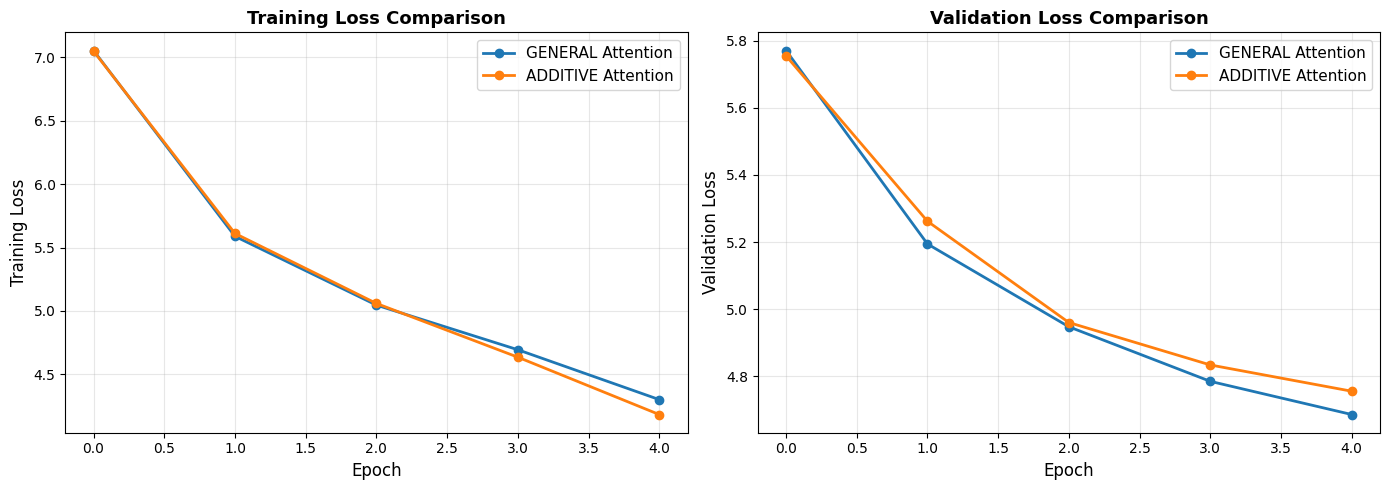

In [51]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss Comparison
ax1 = axes[0]
for att_type in attention_types:
    ax1.plot(all_train_losses[att_type], marker='o', label=f'{att_type.upper()} Attention', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Loss Comparison
ax2 = axes[1]
for att_type in attention_types:
    ax2.plot(all_valid_losses[att_type], marker='o', label=f'{att_type.upper()} Attention', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Validation Loss Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/attention_comparison_losses.png', dpi=150, bbox_inches='tight')
plt.show()


PERFORMANCE COMPARISON TABLE
Attention Type  Test Loss  Test Perplexity
       general   3.786727        44.111769
      additive   3.835480        46.315670



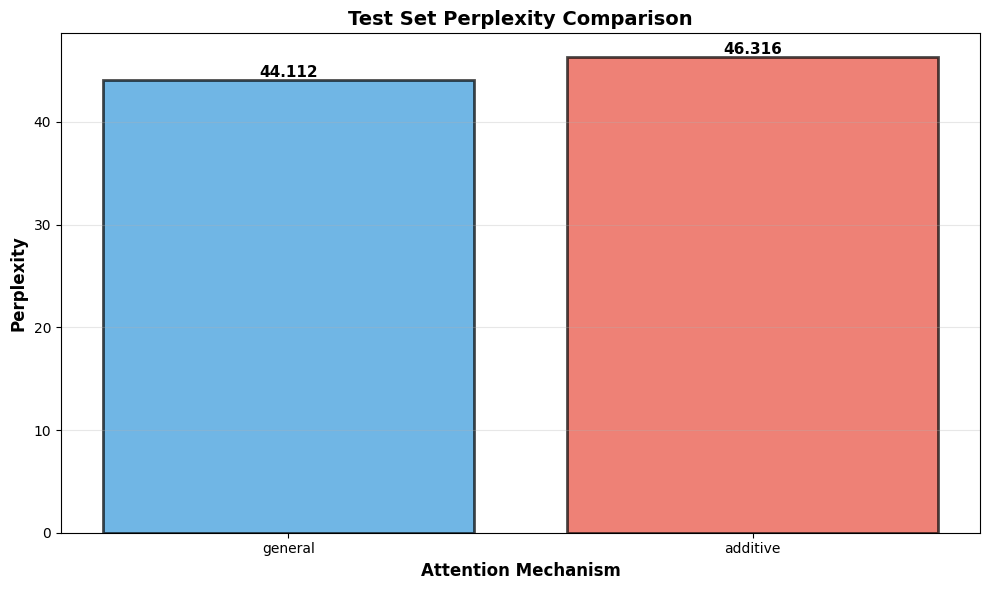

In [52]:
# Performance Metrics Comparison
import pandas as pd

comparison_data = {
    'Attention Type': attention_types,
    'Test Loss': [all_test_losses[att] for att in attention_types],
    'Test Perplexity': [all_perplexities[att] for att in attention_types]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70 + "\n")

# Create bar plot for test perplexity
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(comparison_df['Attention Type'], comparison_df['Test Perplexity'],
              color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)

ax.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
ax.set_xlabel('Attention Mechanism', fontsize=12, fontweight='bold')
ax.set_title('Test Set Perplexity Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('models/perplexity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Visualization: Attention Maps

Now let's visualize attention maps for both attention mechanisms to understand how they focus on different parts of the input.

In [53]:
# Get a sample for attention visualization
sample_idx = 20
sample = test[sample_idx]
print(f"English (Source): {sample[0]}")
print(f"Sinhala (Target): {sample[1]}\n")

# Process sample for all attention types
attention_maps = {}
predictions = {}

for att_type in attention_types:
    print(f"\nGenerating predictions with {att_type.upper()} attention...")

    model = all_models[att_type]
    model.eval()

    src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device).reshape(1, -1)
    trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device).reshape(1, -1)

    with torch.no_grad():
        output, attentions = model(src_text, trg_text)

    # Process output
    output = output.squeeze(0)[1:]  # Remove batch and SOS token
    output_max = output.argmax(1)

    # Map to tokens
    trg_mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    trg_tokens = ['<sos>'] + [trg_mapping[token.item()] for token in output_max]

    # Store results
    attention_maps[att_type] = attentions[0, 0, :, :].cpu()  # First head, first batch
    predictions[att_type] = trg_tokens

    # NEW: Remove <sos> and <eos> tokens for clean output display
    clean_tokens = [token for token in trg_tokens if token not in ['<sos>', '<eos>']]
    clean_prediction = ' '.join(clean_tokens)

    print(f"Generated prediction (raw): {' '.join(trg_tokens[:10])}")
    print(f"Generated prediction (clean): {clean_prediction}\n")

English (Source): dont put your hand up to me.
Sinhala (Target): උඹලා ගේ අත් මට තියන්න එපා.


Generating predictions with GENERAL attention...
Generated prediction (raw): <sos> මට අත වලට අත එපා . <eos> .
Generated prediction (clean): මට අත වලට අත එපා . .


Generating predictions with ADDITIVE attention...
Generated prediction (raw): <sos> මට අත <unk> අත එපා . <eos> .
Generated prediction (clean): මට අත <unk> අත එපා . .



In [54]:
# Get a sample for attention visualization
sample_idx = 2000
sample = test[sample_idx]
print(f"English (Source): {sample[0]}")
print(f"Sinhala (Target): {sample[1]}\n")

# Process sample for all attention types
attention_maps = {}
predictions = {}

for att_type in attention_types:
    print(f"\nGenerating predictions with {att_type.upper()} attention...")

    model = all_models[att_type]
    model.eval()

    src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device).reshape(1, -1)
    trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device).reshape(1, -1)

    with torch.no_grad():
        output, attentions = model(src_text, trg_text)

    # Process output
    output = output.squeeze(0)[1:]  # Remove batch and SOS token
    output_max = output.argmax(1)

    # Map to tokens
    trg_mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    trg_tokens = ['<sos>'] + [trg_mapping[token.item()] for token in output_max]

    # Store results
    attention_maps[att_type] = attentions[0, 0, :, :].cpu()  # First head, first batch
    predictions[att_type] = trg_tokens

    print(f"Generated prediction: {' '.join(trg_tokens[:10])}...")

English (Source): i brought you some molding.
Sinhala (Target): මම මේ බඩු වගයක් ගෙනාවා.


Generating predictions with GENERAL attention...
Generated prediction: <sos> ඔයාට ඔයාව ගෙනාවා ගෙනාවා <eos> <eos> <eos>...

Generating predictions with ADDITIVE attention...
Generated prediction: <sos> ඔයාට <unk> ටිකක් ගෙනාවා . <eos> <eos>...


/tmp/ipython-input-115949457.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(src_tokens[:len(attention[0])], rotation=45, ha='right', fontsize=9)
/tmp/ipython-input-115949457.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(predictions[att_type][:len(attention)], fontsize=9)
/tmp/ipython-input-115949457.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(src_tokens[:len(attention[0])], rotation=45, ha='right', fontsize=9)
/tmp/ipython-input-115949457.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(predictions[att_type][:len(attention)], fontsize=9)
/tmp/ipython-input

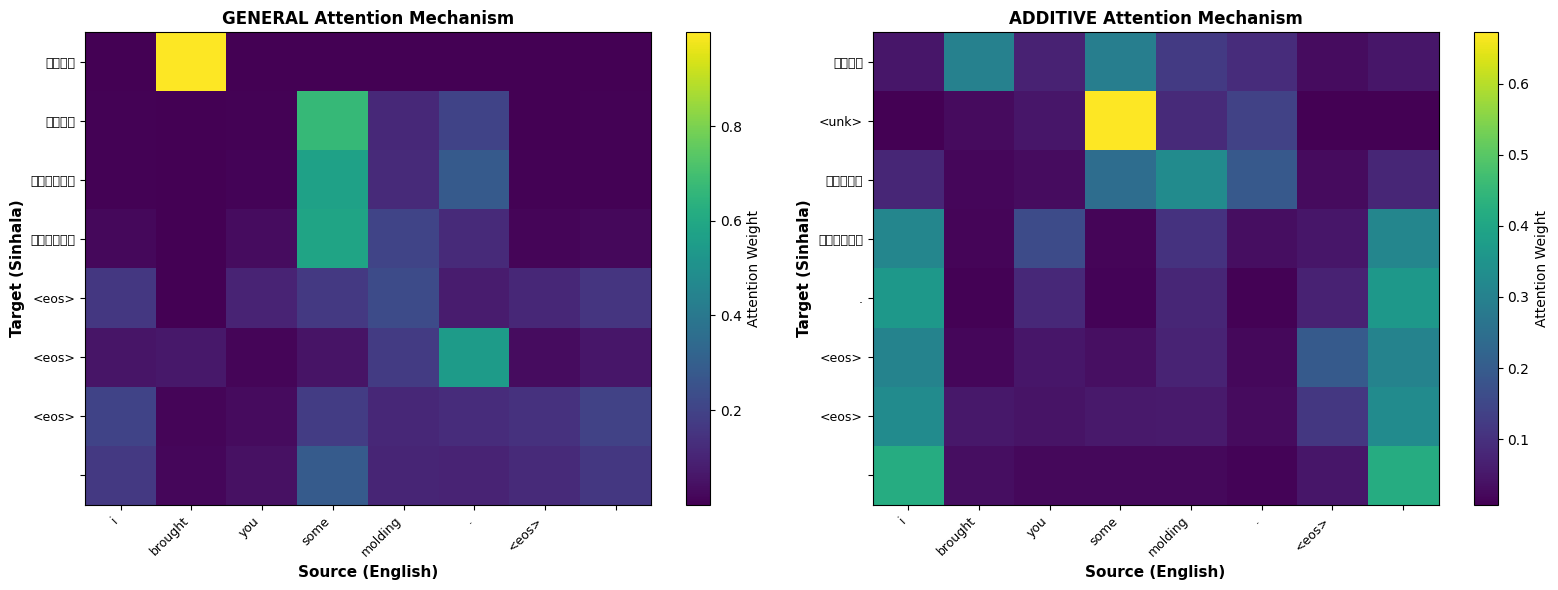

In [55]:
# Visualize attention maps for both mechanisms
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, att_type in enumerate(attention_types):
    ax = axes[idx]

    attention = attention_maps[att_type].squeeze(1).detach().numpy()

    im = ax.imshow(attention, cmap='viridis', aspect='auto')

    # Set labels
    ax.set_xticklabels(src_tokens[:len(attention[0])], rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(predictions[att_type][:len(attention)], fontsize=9)

    ax.set_xlabel('Source (English)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Target (Sinhala)', fontsize=11, fontweight='bold')
    ax.set_title(f'{att_type.upper()} Attention Mechanism', fontsize=12, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=10)

plt.tight_layout()
plt.savefig('models/attention_maps_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipython-input-462724918.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, ha='right', fontsize=10)
/tmp/ipython-input-462724918.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=10)
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3476 (\N{SINHALA LETTER OYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3514 (\N{SINHALA LETTER YAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3535 (\N{SINHALA VOWEL SIGN AELA-PILLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout

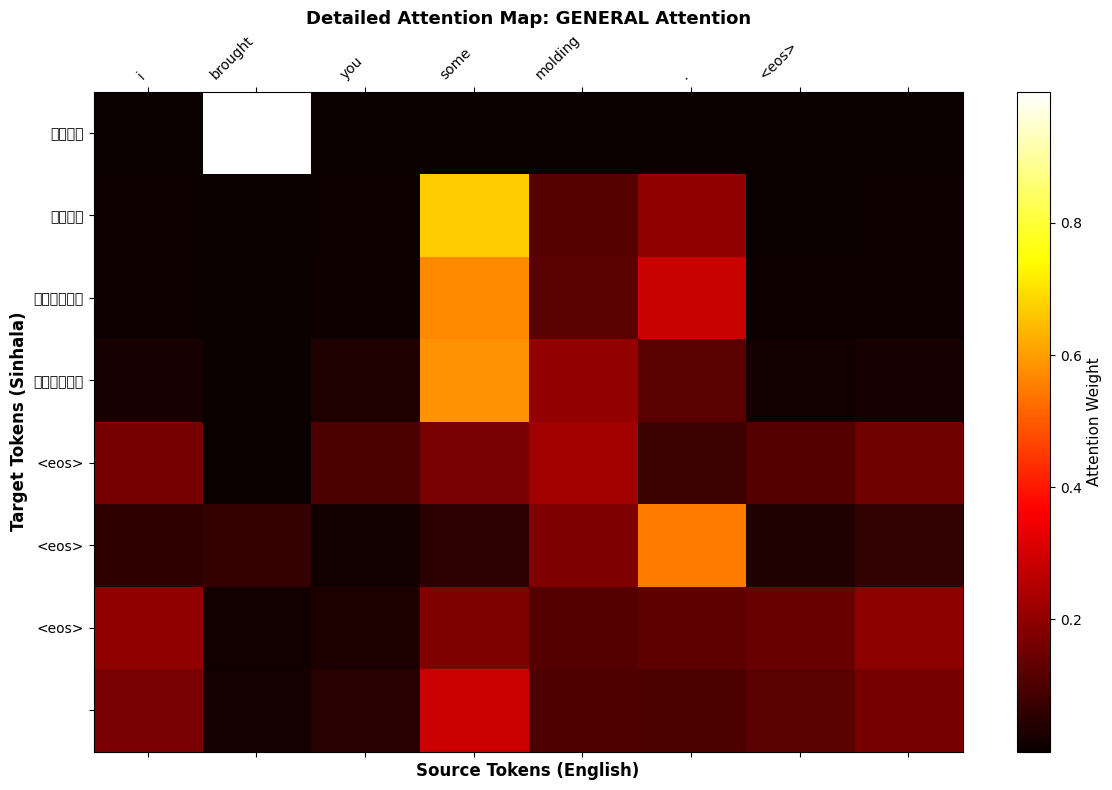

/tmp/ipython-input-462724918.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, ha='right', fontsize=10)
/tmp/ipython-input-462724918.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=10)
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3476 (\N{SINHALA LETTER OYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3514 (\N{SINHALA LETTER YAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-462724918.py:26: UserWarning: Glyph 3535 (\N{SINHALA VOWEL SIGN AELA-PILLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout

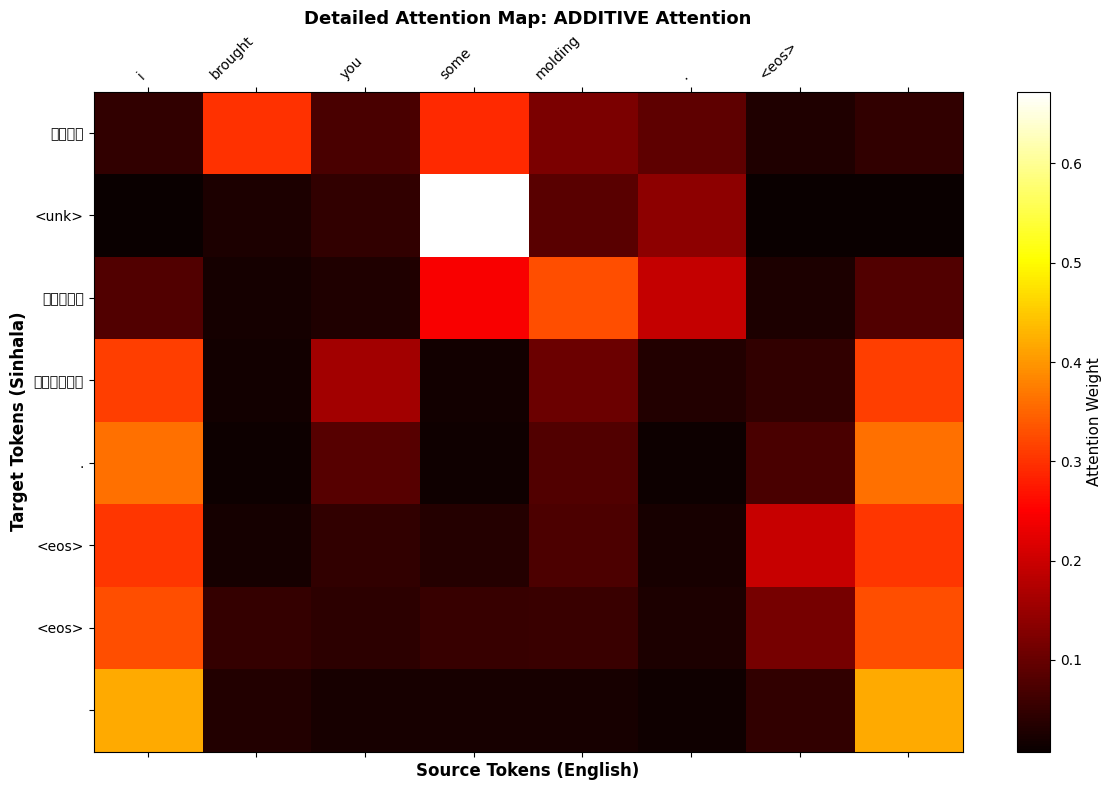

In [56]:
# Generate individual detailed attention maps for each mechanism
for att_type in attention_types:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    attention = attention_maps[att_type].squeeze(1).detach().numpy()

    cax = ax.matshow(attention, cmap='hot', aspect='auto')

    # Limit display to first 20 tokens for clarity
    max_tokens = min(20, len(attention))

    y_ticks = predictions[att_type][:max_tokens]
    x_ticks = src_tokens[:len(attention[0])][:20]

    ax.set_xticklabels(x_ticks, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(y_ticks, fontsize=10)

    ax.set_xlabel('Source Tokens (English)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Target Tokens (Sinhala)', fontsize=12, fontweight='bold')
    ax.set_title(f'Detailed Attention Map: {att_type.upper()} Attention', fontsize=13, fontweight='bold')

    cbar = plt.colorbar(cax, ax=ax)
    cbar.set_label('Attention Weight', fontsize=11)

    plt.tight_layout()
    plt.savefig(f'models/attention_map_{att_type}_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()